In [1]:
import numpy as np
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning
import matplotlib.pyplot as plt
from tqdm import tqdm

# Reuse some code of SKLearn documentation

We see how the Dictionary Learning is supposed to work on some basic sparse signal.

In [2]:
n_samples = 1000
n_features = 2

X, dictionary, code = make_sparse_coded_signal(
    n_samples=n_samples, n_components=15, n_features=n_features, n_nonzero_coefs=10,
    random_state=42,
)
print(f"The sparse signals dataset is made of {X.shape[1]} samples of size {X.shape[0]} each.")
print("Sample 0 from X:", X[:, 0])

dict_learner = DictionaryLearning(
    n_components=15, transform_algorithm='lasso_lars', random_state=42,
)
X_transformed = dict_learner.fit_transform(X)

The sparse signals dataset is made of 1000 samples of size 2 each.
Sample 0 from X: [2.19620009 3.9065111 ]


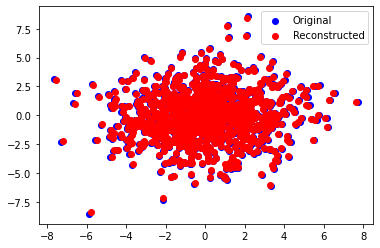

In [3]:
plt.scatter(X[0,:], X[1, :], color="blue", label="Original")

X_hat = X_transformed @ dict_learner.components_
plt.scatter(X_hat[0,:], X_hat[1, :], color="red", label="Reconstructed")

plt.legend()
plt.show()

In [4]:
np.mean(X_transformed == 0)

X_hat = X_transformed @ dict_learner.components_
np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1))

0.0002138652048926348

## Study evolution of error with time/new samples

In [19]:
n_samples = 10000
n_features = 2

X, dictionary, code = make_sparse_coded_signal(
    n_samples=n_samples, n_components=15, n_features=n_features, n_nonzero_coefs=10,
    random_state=42,
)

def study_evolution_dictionary_through_time(X, n_samples_range):
    dictionaries = []
    for n_samples in tqdm(n_samples_range):
        dict_learner = DictionaryLearning(
            n_components=15, transform_algorithm='lasso_lars', random_state=42,
        )
        dict_learner.fit(X[:n_samples])
        
        dictionaries.append(dict_learner)
    
    return dictionaries


def study_evolution_error_through_time(X, n_samples_range):
    losses = []
    for n_samples in tqdm(n_samples_range):
        X_data = X[:, :n_samples]
        dict_learner = DictionaryLearning(
            n_components=15, transform_algorithm='lasso_lars', random_state=42,
        )
        X_transformed = dict_learner.fit_transform(X_data)
        X_hat = X_transformed @ dict_learner.components_
        
        loss = np.mean(np.sum((X_hat - X_data)[:10] ** 2, axis=1) / np.sum(X_data[:10] ** 2, axis=1))
        losses.append(loss)
    
    return losses


n_samples_log_range = np.logspace(1, 5, 20).astype(int)
# all_dictionaries = study_evolution_dictionary_through_time(X, n_samples_log_range)

In [20]:
l2_losses = study_evolution_dictionary_through_time(X, n_samples_log_range)

100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


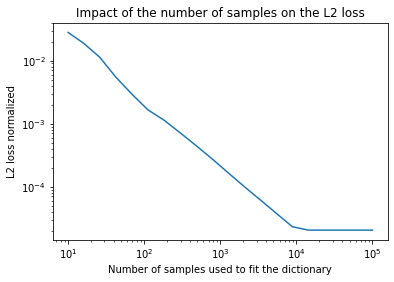

In [23]:
plt.loglog(n_samples_log_range, l2_losses)
plt.xlabel("Number of samples used to fit the dictionary")
plt.ylabel("L2 loss normalized")
plt.title("Impact of the number of samples on the L2 loss")
plt.show()

# Evaluate parameters

In [3]:
import numpy as np

from online_learning import eval_n_components, eval_alpha
from online_learning.visualizations import plot_alphas_losses_sparsities, plot_n_components_losses_sparsities
from online_learning.datasets import make_sparse_data

In [4]:
n_samples = 1000
n_features = 2

X = make_sparse_data(n_samples, n_features)

In [7]:
X

array([[ 2.19620009,  0.20373813, -0.84070862, ...,  2.34820895,
         1.93341199, -1.15443101],
       [ 3.9065111 , -1.35778536,  1.44424431, ...,  0.92921493,
        -1.56862175, -2.14824326]])

100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


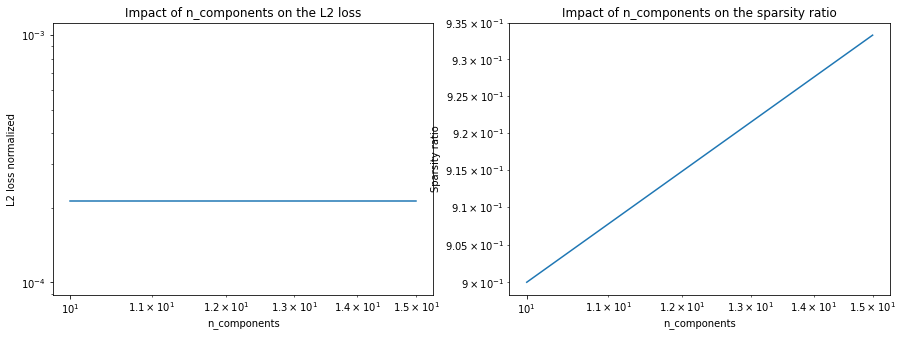

In [3]:
losses, sparse_ratios = eval_n_components([10, 15], X)

plot_n_components_losses_sparsities([10, 15], losses, sparse_ratios)

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


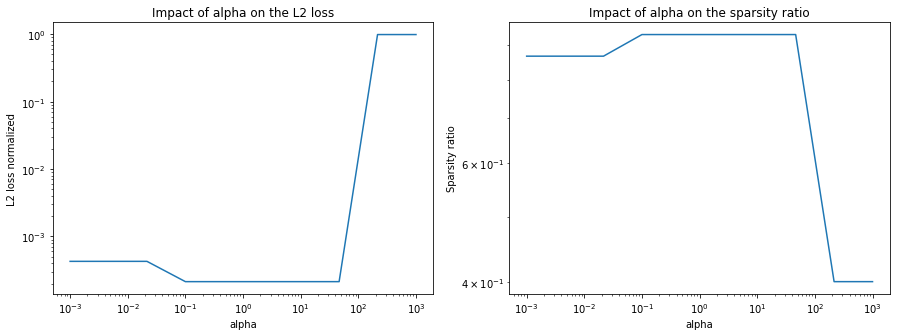

In [6]:
alphas = np.logspace(-3, 3, 10)
losses_alphas, sparse_alphas = eval_alpha(alphas, X)
    
plot_alphas_losses_sparsities(alphas, losses_alphas, sparse_alphas)

## FaceAll dataset

In [1]:
from online_learning.datasets import make_faces
from sklearn.decomposition import DictionaryLearning

X, y = make_faces()

In [2]:
print(X.shape)

(2250, 131)


In [3]:
dict_learner = DictionaryLearning(
    n_components=15, transform_algorithm='lasso_lars', random_state=42,
)
dict_learner.fit(X)

DictionaryLearning(n_components=15, random_state=42,
                   transform_algorithm='lasso_lars')

(2250, 131) (2250, 15) (15, 131)
Label: 3
15


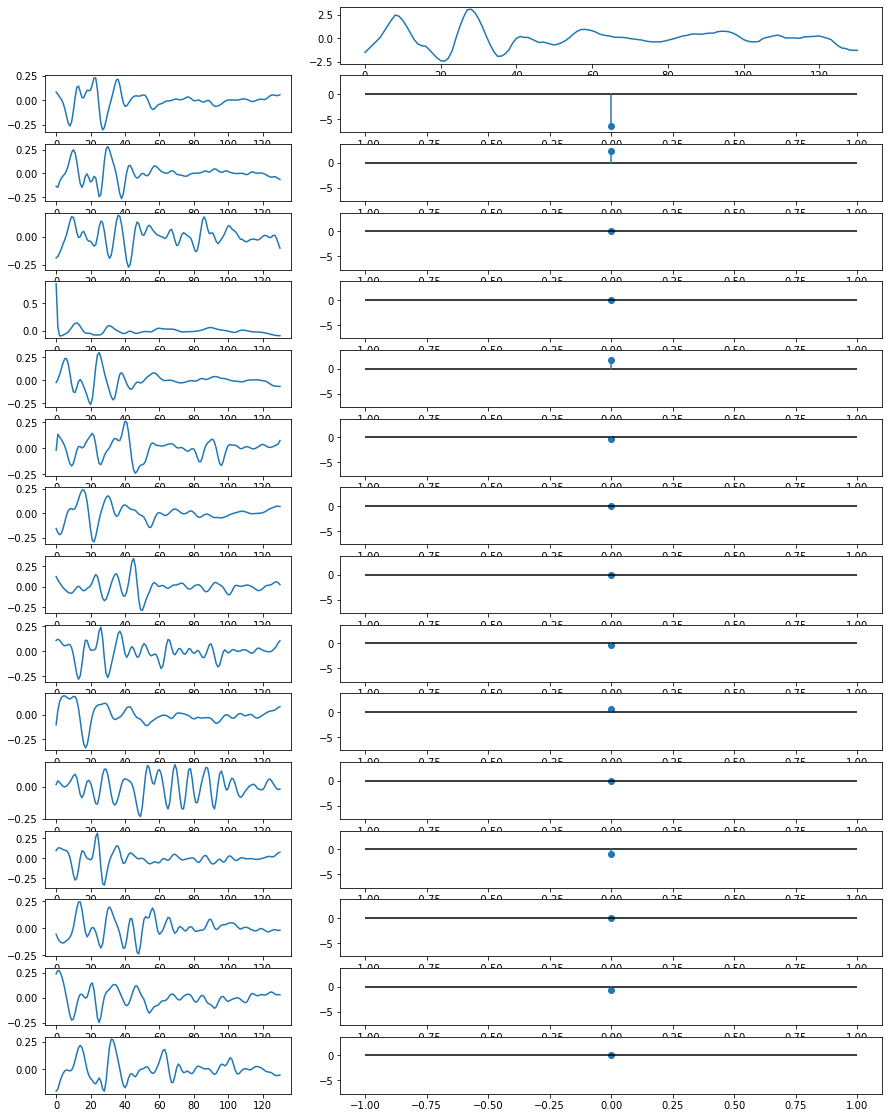

In [30]:
from online_learning.metrics import sparsity_ratio
import numpy as np
import matplotlib.pyplot as plt

def plot_DL(signal, Z, D, figsize=(15, 20)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    (atom_length, n_atoms) = np.shape(D)
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    print(n_atoms)
    margin_y = 0.15 * (np.max(Z) - np.min(Z))
    min_y, max_y = np.min(Z) - margin_y, np.max(Z) + margin_y
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(D[:, i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
#        plt.plot(Z[:, i])
        plt.scatter(0, Z[i])
        plt.plot([0, 0], [0, Z[i]])
        plt.ylim((min_y, max_y))
#        plt.hlines(0, 0, Z[:, i].shape[0], color="k")
        plt.hlines(0, -1, 1, color="k")
    plt.show()
        

X_transformed = dict_learner.transform(X)
D = dict_learner.components_

print(X.shape, X_transformed.shape, D.shape)

ind = 102
print("Label:", y[ind])
plot_DL(X[ind, :], X_transformed[ind,:].T, D.T)